In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
# Determine the absolute path to your training data folder.
project_root = os.path.abspath(
    os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(), '..')
)

# Insert project_root to sys.path if needed.
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Build the path to the data folder (assuming your data folder is directly under the project root)
data_dir = os.path.join(project_root, 'data')
data_small_dir = os.path.join(project_root, 'data_small')

print("Project root:", project_root)
print("Data directory:", data_dir)

from models import get_model, effnetv2b0_base, effnetv2b3_base,train_model

from keras.models import Model
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

Project root: /home/phigep/fh/face-mask-detection
Data directory: /home/phigep/fh/face-mask-detection/data


2025-01-25 22:55:51.354005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737842151.366070   31309 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737842151.369313   31309 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 22:55:51.381836: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1737842153.698349   31309 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21

In [3]:
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
test_small_dir = os.path.join(data_small_dir, 'test')

In [4]:
BATCH_SIZE = 32
ORIGINAL_IMAGE_SIZE = (None, None)  # Allow variable sizes
TARGET_IMAGE_SIZE = (224, 224)       # EfficientNetV2's expected input size
EPOCHS = 25
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
from preprocessing import get_augmented_dataset
train_dataset = get_augmented_dataset(train_dir)
test_dataset = get_augmented_dataset(test_dir,batch_size=1,shuffle=False)
test_small_dataset = get_augmented_dataset(test_small_dir,batch_size=1, shuffle=False)


Found 109638 files belonging to 2 classes.
Found 19351 files belonging to 2 classes.
Found 1132 files belonging to 2 classes.


In [6]:
enetb0_model = get_model(effnetv2b0_base,input_dim=(224,224,3), resize_dim=(224,224,3), classes=2,classifier_activation="sigmoid", training_base=True)

In [7]:
from keras.optimizers import AdamW
optimizer = AdamW(learning_rate=5e-5)

In [8]:
enetb0_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

change back to python to train:

In [9]:

enetb0_model,history = train_model(checkpoint_dir="./checkpoints/",
                                   epochs=3,
                                   model=enetb0_model,
                                   train_data=train_dataset,
                                   val_data=test_dataset,
                                   )

Epoch 1/3


I0000 00:00:1737842184.860585   32197 service.cc:148] XLA service 0x772fa8005b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737842184.860693   32197 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-25 22:56:26.005775: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737842188.461514   32197 cuda_dnn.cc:529] Loaded cuDNN version 90600


   3/3427 ━━━━━━━━━━━━━━━━━━━━ 2:31 44ms/step - accuracy: 0.5972 - loss: 0.6839   

I0000 00:00:1737842206.425650   32197 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3427/3427 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9874 - loss: 0.0540
Epoch 1: val_loss improved from inf to 0.00062, saving model to ./checkpoints/functional_1.keras
3427/3427 ━━━━━━━━━━━━━━━━━━━━ 343s 87ms/step - accuracy: 0.9874 - loss: 0.0540 - val_accuracy: 0.9998 - val_loss: 6.2384e-04 - learning_rate: 5.0000e-05
Epoch 2/3
1766/3427 ━━━━━━━━━━━━━━━━━━━━ 1:18 47ms/step - accuracy: 0.9994 - loss: 0.0017

KeyboardInterrupt: 

In [11]:
from keras.models import load_model
enetb0_model = load_model("./checkpoints/functional_1.keras")

2025-01-25 23:03:32.589305: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


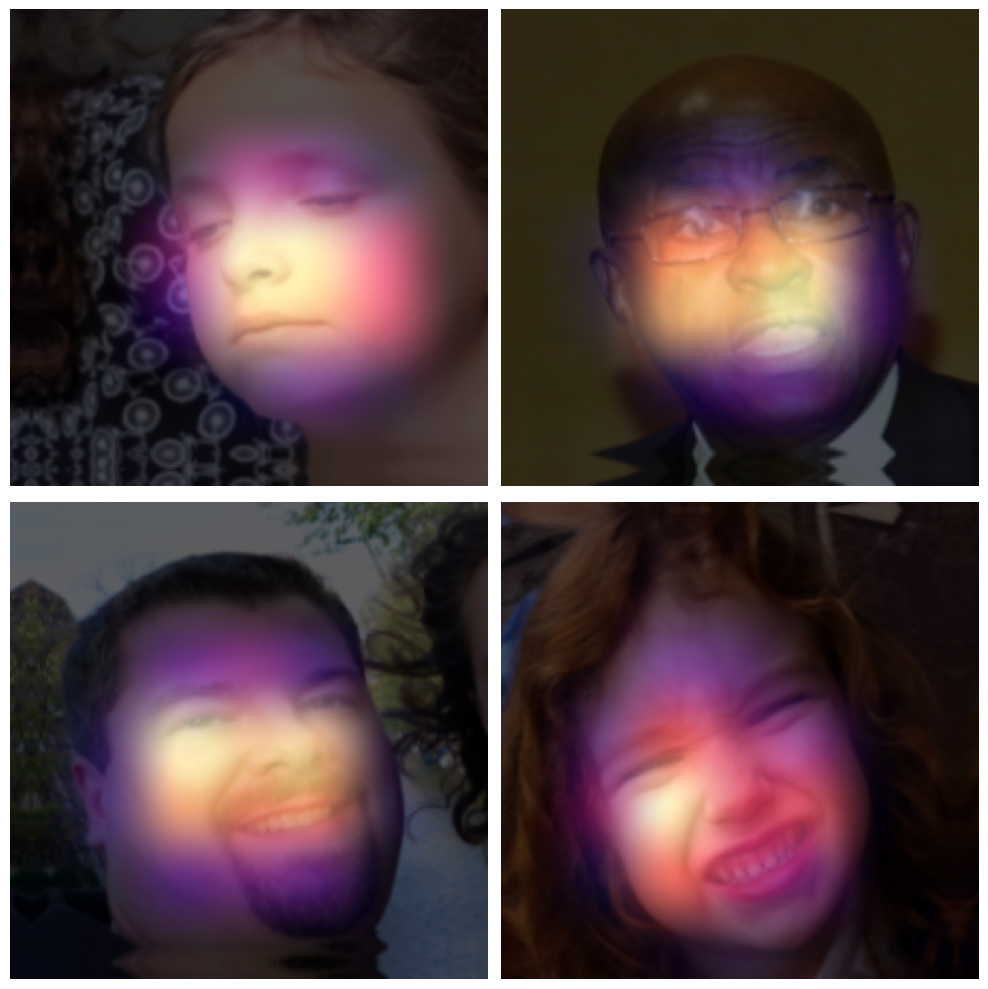

In [12]:
from eval import make_gradcam_heatmap, superimpose_gradcam,plot_images_grid
import matplotlib.pyplot as plt
final_images=[]
for images, labels in test_dataset.take(4):
    heatmap = make_gradcam_heatmap(model=enetb0_model,
                         last_conv_layer_name="efficientnetv2-b0",
                         img_array=images,
                         )
    final = superimpose_gradcam(heatmap=heatmap, img=images[0],alpha=2)
    final_images.append(final)
p=plot_images_grid(final_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[0, 1, 0, 1]
[0, 1, 0, 1]


2025-01-25 23:03:43.795653: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


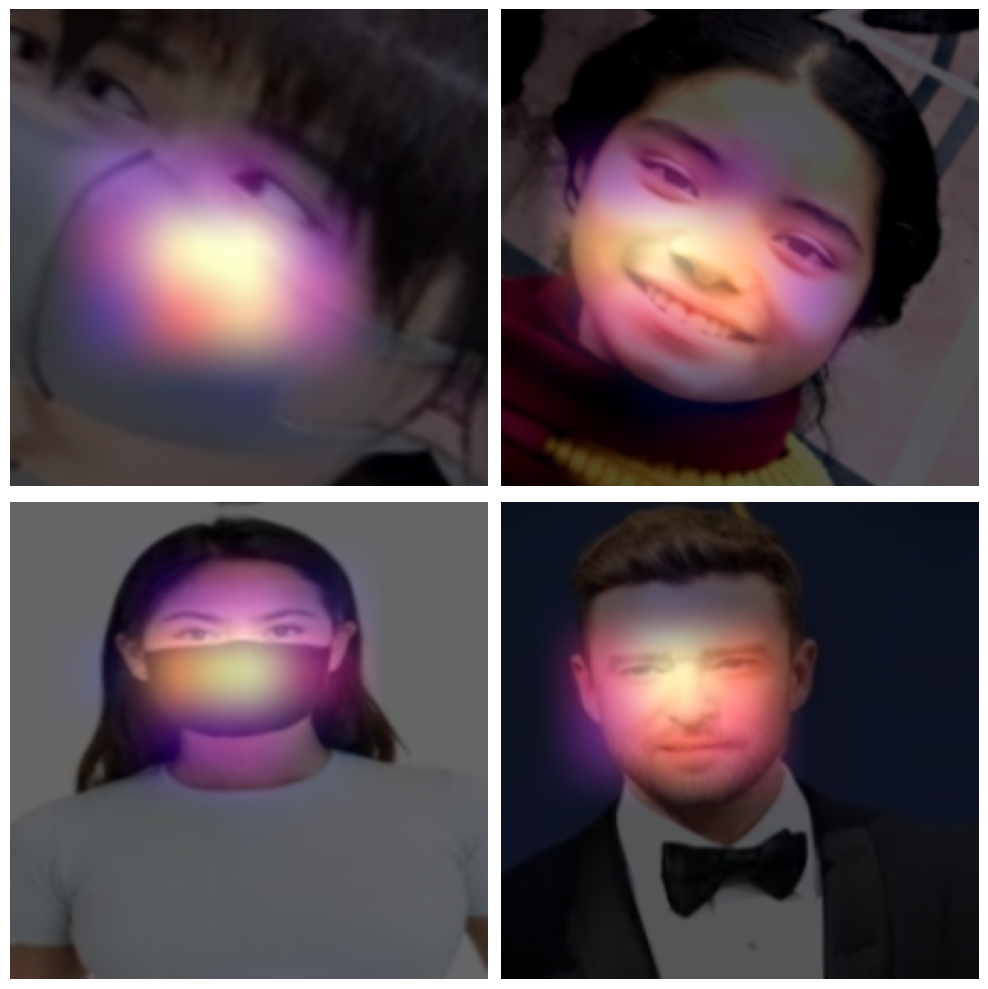

In [13]:
import numpy as np
final_images=[]
preds = []
labels = []
for images, label in test_small_dataset.take(4):
    heatmap = make_gradcam_heatmap(model=enetb0_model,
                         last_conv_layer_name="efficientnetv2-b0",
                         img_array=images,
                         )
    pred= enetb0_model.predict(images)
    preds.append(int(np.argmax(pred)))
    labels.append(int(np.argmax(label)))
    final = superimpose_gradcam(heatmap=heatmap, img=images[0],alpha=2)
    final_images.append(final)
p=plot_images_grid(final_images)
print(labels)
print(preds)

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, confusion_matrix, classification_report

def evaluate_model(test_dataset, y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    classes = np.unique(y_true)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    misclassified = []
    for (image, label) in test_dataset:
        idx = len(misclassified)
        pred = y_pred[idx]
        if np.argmax(label.numpy(),axis=1) != pred:
            misclassified.append(image.numpy())
    return {'accuracy': acc, 'f1_score': f1, 'matthews_corrcoef': mcc, 'classification_report': report}, misclassified


In [15]:
def get_y_true(test_dataset):
    y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
    return y_true
y_true = get_y_true(test_dataset)
y_true = np.argmax(y_true, axis=1)

In [16]:
from sklearn.metrics import accuracy_score,f1_score,matthews_corrcoef, confusion_matrix
y_preds= enetb0_model.predict(test_dataset)
y_preds = np.argmax(y_preds, axis=1)

19351/19351 ━━━━━━━━━━━━━━━━━━━━ 104s 5ms/step


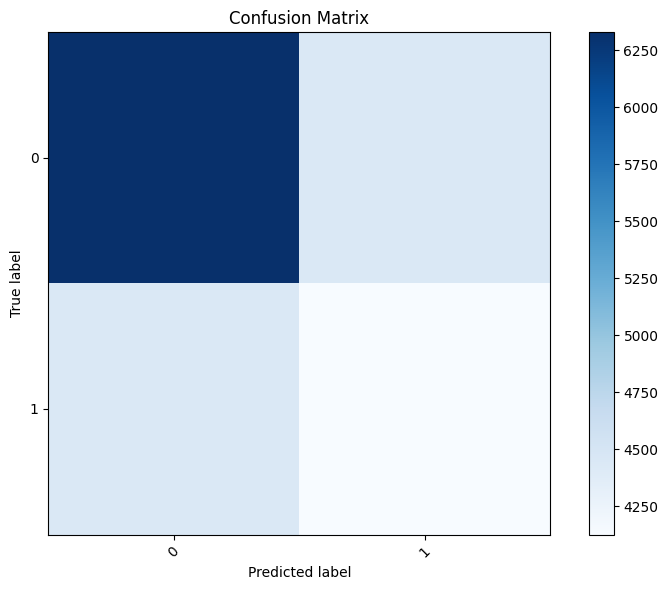

2025-01-25 23:06:08.905720: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
report, misclassified_images = evaluate_model(test_dataset,y_true,y_preds)

In [18]:
report

{'accuracy': 0.5402821559609322,
 'f1_score': 0.5402821559609322,
 'matthews_corrcoef': np.float64(0.06849148435080375),
 'classification_report': {'0': {'precision': 0.5872691843741301,
   'recall': 0.5872691843741301,
   'f1-score': 0.5872691843741301,
   'support': 10777.0},
  '1': {'precision': 0.48122229997667365,
   'recall': 0.48122229997667365,
   'f1-score': 0.48122229997667365,
   'support': 8574.0},
  'accuracy': 0.5402821559609322,
  'macro avg': {'precision': 0.5342457421754019,
   'recall': 0.5342457421754019,
   'f1-score': 0.5342457421754019,
   'support': 19351.0},
  'weighted avg': {'precision': 0.5402821559609322,
   'recall': 0.5402821559609322,
   'f1-score': 0.5402821559609322,
   'support': 19351.0}}}